In [1]:
!pip install scikit-optimize

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

from scikit_mol.fingerprints import MorganFingerprintTransformer
from scikit_mol.conversions import SmilesToMolTransformer

from sklearn.pipeline import make_pipeline

In [4]:
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from skopt import gp_minimize

In [5]:
full_set = False

if full_set:
    csv_file = "SLC6A4_active_excape_export.csv"
    if not os.path.exists(csv_file):
        import urllib.request

        url = "https://ndownloader.figshare.com/files/25747817"
        urllib.request.urlretrieve(url, csv_file)
else:
    csv_file = "../tests/data/SLC6A4_active_excapedb_subset.csv"

data = pd.read_csv(csv_file)
trf = SmilesToMolTransformer()
data["ROMol"] = trf.transform(data.SMILES.values).flatten()

In [6]:
pipe = make_pipeline(MorganFingerprintTransformer(), Ridge())
pipe

Pipeline(steps=[('morganfingerprinttransformer',
                 MorganFingerprintTransformer()),
                ('ridge', Ridge())])

In [7]:
print(pipe.get_params())

{'memory': None, 'steps': [('morganfingerprinttransformer', MorganFingerprintTransformer()), ('ridge', Ridge())], 'verbose': False, 'morganfingerprinttransformer': MorganFingerprintTransformer(), 'ridge': Ridge(), 'morganfingerprinttransformer__fpSize': 2048, 'morganfingerprinttransformer__parallel': False, 'morganfingerprinttransformer__radius': 2, 'morganfingerprinttransformer__safe_inference_mode': False, 'morganfingerprinttransformer__useBondTypes': True, 'morganfingerprinttransformer__useChirality': False, 'morganfingerprinttransformer__useCounts': False, 'morganfingerprinttransformer__useFeatures': False, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.0001}


In [8]:
max_bits = 4096

morgan_space = [
    Categorical([True, False], name="morganfingerprinttransformer__useCounts"),
    Categorical([True, False], name="morganfingerprinttransformer__useFeatures"),
    Integer(512, max_bits, name="morganfingerprinttransformer__fpSize"),
    Integer(1, 3, name="morganfingerprinttransformer__radius"),
]


regressor_space = [Real(1e-2, 1e3, "log-uniform", name="ridge__alpha")]

search_space = morgan_space + regressor_space

In [9]:
@use_named_args(search_space)
def objective(**params):
    for key, value in params.items():
        print(f"{key}:{value} - {type(value)}")
    pipe.set_params(**params)

    return -np.mean(
        cross_val_score(
            pipe,
            data.ROMol,
            data.pXC50,
            cv=2,
            n_jobs=-1,
            scoring="neg_mean_absolute_error",
        )
    )

In [10]:
pipe_gp = gp_minimize(objective, search_space, n_calls=10, random_state=0)
"Best score=%.4f" % pipe_gp.fun

morganfingerprinttransformer__useCounts:False - <class 'bool'>
morganfingerprinttransformer__useFeatures:False - <class 'bool'>
morganfingerprinttransformer__fpSize:3587 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:3 - <class 'numpy.int64'>
ridge__alpha:13.116515715358098 - <class 'float'>


morganfingerprinttransformer__useCounts:True - <class 'bool'>
morganfingerprinttransformer__useFeatures:True - <class 'bool'>
morganfingerprinttransformer__fpSize:715 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:2 - <class 'numpy.int64'>
ridge__alpha:2.445263057083992 - <class 'float'>


morganfingerprinttransformer__useCounts:False - <class 'bool'>
morganfingerprinttransformer__useFeatures:True - <class 'bool'>
morganfingerprinttransformer__fpSize:1920 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:3 - <class 'numpy.int64'>
ridge__alpha:0.48638570461894715 - <class 'float'>
morganfingerprinttransformer__useCounts:False - <class 'bool'>
morganfingerprinttransformer__useFeatures:True - <class 'bool'>
morganfingerprinttransformer__fpSize:3942 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:1 - <class 'numpy.int64'>
ridge__alpha:224.09712855921126 - <class 'float'>
morganfingerprinttransformer__useCounts:True - <class 'bool'>
morganfingerprinttransformer__useFeatures:False - <class 'bool'>
morganfingerprinttransformer__fpSize:2377 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:2 - <class 'numpy.int64'>
ridge__alpha:40.10174523739503 - <class 'float'>


morganfingerprinttransformer__useCounts:False - <class 'bool'>
morganfingerprinttransformer__useFeatures:False - <class 'bool'>
morganfingerprinttransformer__fpSize:3231 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:1 - <class 'numpy.int64'>
ridge__alpha:2.333469328026273 - <class 'float'>
morganfingerprinttransformer__useCounts:True - <class 'bool'>
morganfingerprinttransformer__useFeatures:False - <class 'bool'>
morganfingerprinttransformer__fpSize:1288 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:1 - <class 'numpy.int64'>
ridge__alpha:0.41754668393896904 - <class 'float'>
morganfingerprinttransformer__useCounts:True - <class 'bool'>
morganfingerprinttransformer__useFeatures:True - <class 'bool'>
morganfingerprinttransformer__fpSize:1897 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:3 - <class 'numpy.int64'>
ridge__alpha:1.777255838269662 - <class 'float'>
morganfingerprinttransformer__useCounts:False - <class 'bool'>
morganfingerprinttra

morganfingerprinttransformer__useCounts:True - <class 'bool'>
morganfingerprinttransformer__useFeatures:True - <class 'bool'>
morganfingerprinttransformer__fpSize:3202 - <class 'numpy.int64'>
morganfingerprinttransformer__radius:2 - <class 'numpy.int64'>
ridge__alpha:0.4219258607446576 - <class 'float'>


'Best score=0.5968'

In [11]:
print("""Best parameters:""")
print({param.name: value for param, value in zip(pipe_gp.space, pipe_gp.x)})

Best parameters:
{'morganfingerprinttransformer__useCounts': False, 'morganfingerprinttransformer__useFeatures': False, 'morganfingerprinttransformer__fpSize': 3231, 'morganfingerprinttransformer__radius': 1, 'ridge__alpha': 2.333469328026273}


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

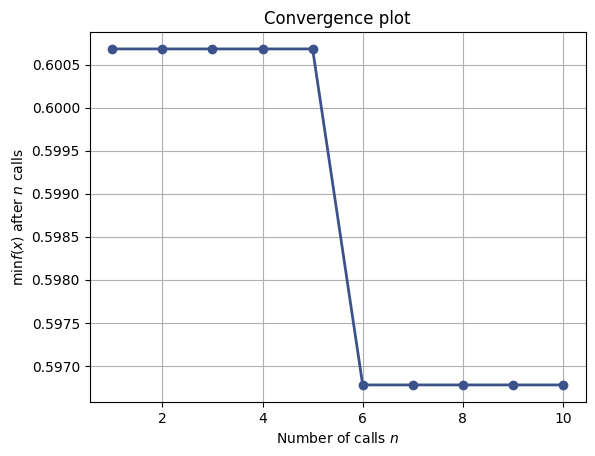

In [12]:
from skopt.plots import plot_convergence

plot_convergence(pipe_gp)